In [1]:
# matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
# pandas
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# numpy
import numpy as np
# keras; not sure which version
# API changes frequently, so...
import keras
from keras.models import Sequential, model_from_json                                            
from keras.layers.core import Dense, Dropout, Activation                       
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD        
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasRegressor
#sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# normal
import time
import os

Using TensorFlow backend.


Versions:

- keras: 2.0.8
- pandas: 0.23.4
- scikit-learn: 0.19.1
- tensorflow: 0.3.0
- theano: 1.0.2

*NOTE using tensorflow backend*

# Helper Functions

## Minkowski Distance

In [2]:
def minkowski_distance(x1, x2, y1, y2, p):
    return ((abs(x2 - x1) ** p) + (abs(y2 - y1)) ** p) ** (1 / p)

## Haversine Distance

In [3]:
# Radius of the earth in kilometers
R = 6378

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    
    
    source: https://stackoverflow.com/a/29546836

    """
    # Convert latitude and longitude to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Find the differences
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Apply the formula 
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    # Calculate the angle (in radians)
    c = 2 * np.arcsin(np.sqrt(a))
    # Convert to kilometers
    km = R * c
    
    return km

## Date-Time

In [4]:
import re

def extract_dateinfo(df, date_col, drop=True, time=False, 
                     start_ref = pd.datetime(1900, 1, 1),
                     extra_attr = False):
    """
    Extract Date (and time) Information from a DataFrame
    Adapted from: https://github.com/fastai/fastai/blob/master/fastai/structured.py
    """
    df = df.copy()
    
    # Extract the field
    fld = df[date_col]
    
    # Check the time
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    # Convert to datetime if not already
    if not np.issubdtype(fld_dtype, np.datetime64):
        df[date_col] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    

    # Prefix for new columns
    pre = re.sub('[Dd]ate', '', date_col)
    pre = re.sub('[Tt]ime', '', pre)
    
    # Basic attributes
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Days_in_month', 'is_leap_year']
    
    # Additional attributes
    if extra_attr:
        attr = attr + ['Is_month_end', 'Is_month_start', 'Is_quarter_end', 
                       'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    
    # If time is specified, extract time information
    if time: 
        attr = attr + ['Hour', 'Minute', 'Second']
        
    # Iterate through each attribute
    for n in attr: 
        df[pre + n] = getattr(fld.dt, n.lower())
        
    # Calculate days in year
    df[pre + 'Days_in_year'] = df[pre + 'is_leap_year'] + 365
        
    if time:
        # Add fractional time of day (0 - 1) units of day
        df[pre + 'frac_day'] = ((df[pre + 'Hour']) + (df[pre + 'Minute'] / 60) + (df[pre + 'Second'] / 60 / 60)) / 24
        
        # Add fractional time of week (0 - 1) units of week
        df[pre + 'frac_week'] = (df[pre + 'Dayofweek'] + df[pre + 'frac_day']) / 7
    
        # Add fractional time of month (0 - 1) units of month
        df[pre + 'frac_month'] = (df[pre + 'Day'] + (df[pre + 'frac_day'])) / (df[pre + 'Days_in_month'] +  1)
        
        # Add fractional time of year (0 - 1) units of year
        df[pre + 'frac_year'] = (df[pre + 'Dayofyear'] + df[pre + 'frac_day']) / (df[pre + 'Days_in_year'] + 1)
        
    # Add seconds since start of reference
    df[pre + 'Elapsed'] = (fld - start_ref).dt.total_seconds()
    
    if drop: 
        df = df.drop(date_col, axis=1)
        
    return df

# Load Data

In [5]:
if not os.path.exists('store.h5'):
# load the data
    data = pd.read_csv('input/train.csv', nrows=5_000_000,
        parse_dates = ['pickup_datetime']).drop(columns='key')
    # remove na
    ## I am not sure what na means
    data = data.dropna()
    with pd.HDFStore('store.h5') as store:
        store['df'] = data
    ## I am not sure what head does either
    data.head()
else:
    with pd.HDFStore('store.h5') as store:
        data = store['df']

# Sanitize Data

In [6]:
clean_data = data[data['fare_amount'].between(left=2.5, right=100)]
clean_data = clean_data.loc[clean_data['passenger_count'] < 6]
# Remove latitude and longtiude outliers
clean_data = clean_data.loc[clean_data['pickup_latitude'].between(40, 42)]
clean_data = clean_data.loc[clean_data['pickup_longitude'].between(-75, -72)]
clean_data = clean_data.loc[clean_data['dropoff_latitude'].between(40, 42)]
clean_data = clean_data.loc[clean_data['dropoff_longitude'].between(-75, -72)]
# add in bins
clean_data['fare-bin'] = pd.cut(clean_data['fare_amount'], bins = list(range(0, 50, 5))).astype(str)
# Uppermost bin
clean_data.loc[clean_data['fare-bin'] == 'nan', 'fare-bin'] = '[45+]'
# Adjust bin so the sorting is correct
clean_data.loc[clean_data['fare-bin'] == '(5, 10]', 'fare-bin'] = '(05, 10]'
# get date-time data
clean_data = extract_dateinfo(clean_data, 'pickup_datetime', drop = False,
                              time = True, start_ref = data['pickup_datetime'].min())

# Feature Engineering

In [7]:
# Absolute difference in latitude and longitude
clean_data['abs_lat_diff'] = (clean_data['dropoff_latitude'] - clean_data['pickup_latitude']).abs()
clean_data['abs_lon_diff'] = (clean_data['dropoff_longitude'] - clean_data['pickup_longitude']).abs()

clean_data['manhattan'] = minkowski_distance(clean_data['pickup_longitude'], clean_data['dropoff_longitude'],
                                             clean_data['pickup_latitude'], clean_data['dropoff_latitude'], 1)

clean_data['euclidean'] = minkowski_distance(clean_data['pickup_longitude'], clean_data['dropoff_longitude'],
                                             clean_data['pickup_latitude'], clean_data['dropoff_latitude'], 2)



clean_data['haversine'] =  haversine_np(clean_data['pickup_longitude'], clean_data['pickup_latitude'],
                                        clean_data['dropoff_longitude'], clean_data['dropoff_latitude']) 

# Read in test data; create same features

In [8]:
test = pd.read_csv('input/test.csv', parse_dates = ['pickup_datetime'])
# Save the id for submission
test_id = list(test.pop('key'))

# Create absolute differences
test['abs_lat_diff'] = (test['dropoff_latitude'] - test['pickup_latitude']).abs()
test['abs_lon_diff'] = (test['dropoff_longitude'] - test['pickup_longitude']).abs()
test = extract_dateinfo(test, 'pickup_datetime', drop = False,
                        time = True, start_ref = data['pickup_datetime'].min())
test['manhattan'] = minkowski_distance(test['pickup_longitude'], test['dropoff_longitude'],
                                       test['pickup_latitude'], test['dropoff_latitude'], 1)

test['euclidean'] = minkowski_distance(test['pickup_longitude'], test['dropoff_longitude'],
                                       test['pickup_latitude'], test['dropoff_latitude'], 2)
test['haversine'] = haversine_np(test['pickup_longitude'], test['pickup_latitude'],
                                 test['dropoff_longitude'], test['dropoff_latitude'])

### Specify features

In [9]:
features = ['abs_lat_diff', 'abs_lon_diff', 'haversine', 'passenger_count',
            'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude',
            'pickup_frac_day', 'pickup_frac_week', 'pickup_frac_year', 'pickup_Elapsed']

# set up Keras Dense ANN

In [10]:
from keras import backend as K

def coeff_determination(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_pred)))
    return ( 1 - SS_res/(SS_tot + K.epsilon()))

def baseline_model():
    # create model
    model = Sequential()
    # need to get the number of all the features we're going to input
    model.add(BatchNormalization(input_shape=(len(features),)))
    model.add(Dense(len(features), activation="relu"))
#     model.add(BatchNormalization(input_shape=(len(features),)))
#     model.add(Dropout(0.25))
# #     model.add(Dense(24, activation="relu"))
#     model.add(Dense(6, activation="relu"))
#     model.add(BatchNormalization(input_shape=(len(features),)))
#     model.add(Dropout(0.25))
    model.add(Dense(1, kernel_initializer='normal'))
#     model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[coeff_determination])
    return model

### Split the training data for training/validation

In [12]:
seed = 4
X_train, X_valid, y_train, y_valid = train_test_split(clean_data, np.array(clean_data['fare_amount']), 
                                                      stratify = clean_data['fare-bin'],
                                                      random_state = seed, test_size = 1_000_000)

In [26]:
# kfold = KFold(n_splits=10, random_state=seed)
X = np.asarray(X_train[features])
# X = X[:30000]
y = np.asarray(y_train)
# y = y[:30000]
model = baseline_model()
# patience is number of epochs with no improvement
train_hist = model.fit(X, y, epochs=10000, batch_size=1000, verbose=1,
                       validation_split=0.2, shuffle=True,
                       callbacks=[keras.callbacks.EarlyStopping('loss', patience=10),
                                  keras.callbacks.EarlyStopping('coeff_determination', patience=10)])
#     save_model(model, modelName)
print('Finished training after {} epochs with accuracy {}'.format(
        train_hist.epoch[-1], train_hist.history['coeff_determination'][-1]))

Train on 3031236 samples, validate on 757810 samples
Epoch 1/10000
3031236/3031236 [==============================] - 19s - loss: 37.5442 - coeff_determination: 0.6538 - val_loss: 24.5726 - val_coeff_determination: 0.7160
Epoch 2/10000
3031236/3031236 [==============================] - 18s - loss: 23.0317 - coeff_determination: 0.7370 - val_loss: 23.5026 - val_coeff_determination: 0.7279
Epoch 3/10000
3031236/3031236 [==============================] - 18s - loss: 22.1967 - coeff_determination: 0.7456 - val_loss: 22.9065 - val_coeff_determination: 0.7349
Epoch 4/10000
3031236/3031236 [==============================] - 17s - loss: 21.6569 - coeff_determination: 0.7518 - val_loss: 22.6568 - val_coeff_determination: 0.7375
Epoch 5/10000
3031236/3031236 [==============================] - 16s - loss: 21.3321 - coeff_determination: 0.7562 - val_loss: 22.2857 - val_coeff_determination: 0.7419
Epoch 6/10000
3031236/3031236 [==============================] - 17s - loss: 21.1222 - coeff_determina

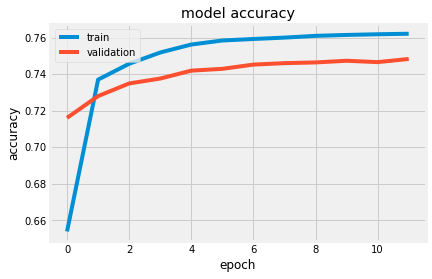

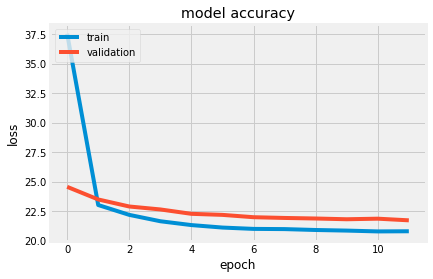

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(train_hist.history['coeff_determination'])
ax.plot(train_hist.history['val_coeff_determination'])
ax.set_title('model accuracy')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(train_hist.history['loss'])
ax.plot(train_hist.history['val_loss'])
ax.set_title('model accuracy')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()

In [28]:
X = np.asarray(X_valid[features])
print(X.shape)
pred = model.predict(X, verbose=False)

(1000000, 12)


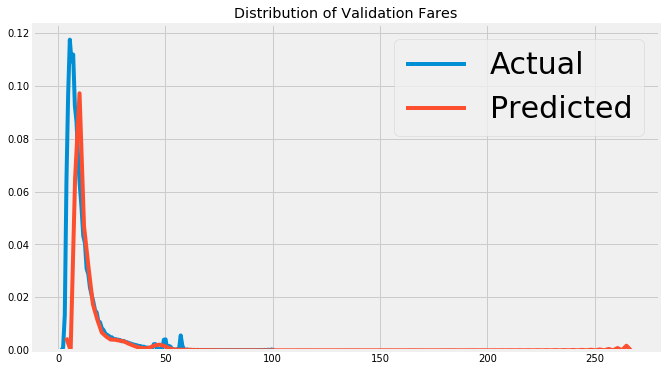

In [29]:
import seaborn as sns
plt.figure(figsize = (10, 6))
sns.kdeplot(y_valid, label = 'Actual')
sns.kdeplot(pred.flatten(), label = 'Predicted')
plt.legend(prop = {'size': 30})
plt.title("Distribution of Validation Fares");

In [31]:
# quick and dirty comparison
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

def metrics(train_pred, valid_pred, y_train, y_valid):
    """Calculate metrics:
       Root mean squared error and mean absolute percentage error"""
    
    # Root mean squared error
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    valid_rmse = np.sqrt(mean_squared_error(y_valid, valid_pred))
    
    # Calculate absolute percentage error
    train_ape = abs((y_train - train_pred) / y_train)
    valid_ape = abs((y_valid - valid_pred) / y_valid)
    
    # Account for y values of 0
    train_ape[train_ape == np.inf] = 0
    train_ape[train_ape == -np.inf] = 0
    valid_ape[valid_ape == np.inf] = 0
    valid_ape[valid_ape == -np.inf] = 0
    
    train_mape = 100 * np.mean(train_ape)
    valid_mape = 100 * np.mean(valid_ape)
    
    return train_rmse, valid_rmse, train_mape, valid_mape

def evaluate_ann(model, X_train, X_valid, y_train, y_valid):
    """Mean absolute percentage error"""
    
    # Make predictions
    train_pred = model.predict(X_train.values)
    valid_pred = model.predict(X_valid.values)
    
    # Get metrics
    train_rmse, valid_rmse, train_mape, valid_mape = metrics(train_pred, valid_pred,
                                                             y_train, y_valid)
    
    print(f'Training:   rmse = {round(train_rmse, 2)} \t mape = {round(train_mape, 2)}')
    print(f'Validation: rmse = {round(valid_rmse, 2)} \t mape = {round(valid_mape, 2)}')

In [ ]:
evaluate_ann(model, X_train[features], X_valid[features], y_train, y_valid)

In [ ]:
y_pred = model.predict(X_valid)
fig = plt.figure()
ax = fig.add_subplot(111)
sns.scatterplot(y_pred.reshape(-1), y_valid, ax=ax,
                label='Regression')
ax.plot([np.nanmin(y_valid), np.nanmax(y_valid)],
        [np.nanmin(y_valid), np.nanmax(y_valid)],
        color='tab:orange', label="Truth Line")
ax.set_xlabel("predicted")
ax.set_ylabel("true")
plt.legend()
plt.tight_layout()
plt.show()

Let's see if we can improve

In [200]:
def new_model():
    # create model
    model = Sequential()
    # need to get the number of all the features we're going to input
    model.add(BatchNormalization(input_shape=(len(features),)))
#     model.add(Dense(24, activation="relu"))
    model.add(Dense(12, activation="tanh"))
    model.add(Dropout(0.25))
#     model.add(Dense(12, activation="relu"))
    model.add(Dense(8, activation="relu"))
    model.add(Dropout(0.25))
    model.add(BatchNormalization(input_shape=(len(features),)))
#     model.add(Dense(6, activation="relu"))
    model.add(Dense(4, activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(1, kernel_initializer='normal'))
#     model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model

In [201]:
seed = 7
np.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=new_model, epochs=100, batch_size=5, verbose=1)
X_train, X_valid, y_train, y_valid = train_test_split(clean_data, np.array(clean_data['fare_amount']), 
                                                      stratify = clean_data['fare-bin'],
                                                      random_state = seed, test_size = 1_000_000)

In [206]:
# kfold = KFold(n_splits=10, random_state=seed)
X = np.asarray(X_train[features])
# X = X[:30000]
y = np.asarray(y_train)
# y = y[:30000]
model = new_model()
# patience is number of epochs with no improvement
train_hist = model.fit(X, y, epochs=10000, batch_size=1000, verbose=1, 
                       callbacks=[keras.callbacks.EarlyStopping('loss', patience=25),
                                  keras.callbacks.EarlyStopping('acc', patience=10)])
#     save_model(model, modelName)
print('Finished training after {} epochs with accuracy {}'.format(
        train_hist.epoch[-1], train_hist.history['acc'][-1]))

Epoch 1/10000
3789046/3789046 [==============================] - 33s - loss: 50.1115 - acc: 0.0206    
Epoch 2/10000
3789046/3789046 [==============================] - 31s - loss: 36.1627 - acc: 0.0260    
Epoch 3/10000
3789046/3789046 [==============================] - 30s - loss: 33.0512 - acc: 0.0285    
Epoch 4/10000
3789046/3789046 [==============================] - 31s - loss: 32.1027 - acc: 0.0271    
Epoch 5/10000
3789046/3789046 [==============================] - 31s - loss: 32.0288 - acc: 0.0271    
Epoch 6/10000
3789046/3789046 [==============================] - 31s - loss: 32.0225 - acc: 0.0272    
Epoch 7/10000
3789046/3789046 [==============================] - 31s - loss: 32.0443 - acc: 0.0272    
Epoch 8/10000
3789046/3789046 [==============================] - 31s - loss: 32.0181 - acc: 0.0271    
Epoch 9/10000
3789046/3789046 [==============================] - 32s - loss: 31.9209 - acc: 0.0272    
Epoch 10/10000
3789046/3789046 [==============================] - 31s - l

In [207]:
X = np.asarray(X_valid[features])
print(X.shape)
pred = model.predict(X, verbose=False)

(1000000, 12)


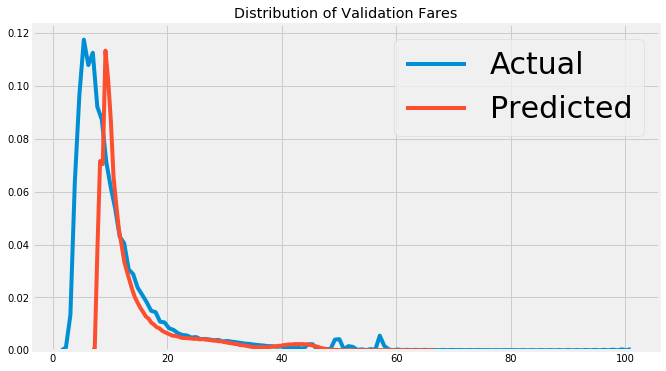

In [208]:
import seaborn as sns
plt.figure(figsize = (10, 6))
sns.kdeplot(y_valid, label = 'Actual')
sns.kdeplot(pred.flatten(), label = 'Predicted')
plt.legend(prop = {'size': 30})
plt.title("Distribution of Validation Fares");

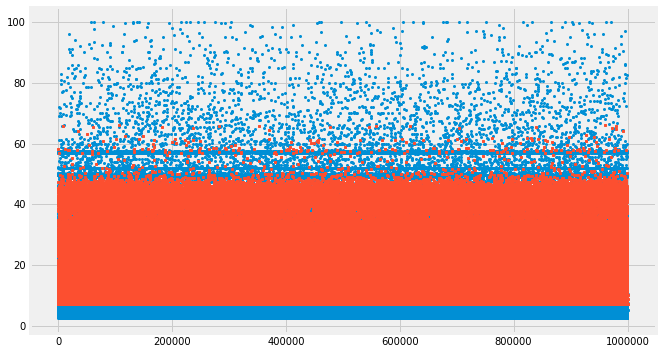

In [209]:
plt.figure(figsize=(10,6))
plt.plot(y_valid, marker='o', ms=2, linestyle='')
plt.plot(pred.flatten(), marker='s', ms=2, linestyle='')
# plt.scatter(np.arange(y_valid.shape[0]), y_valid, marker='o')
# plt.scatter(np.arange(y_valid.shape[0]), pred.flatten(), marker='s')